In [23]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
import torch
print(torch.__version__)

1.13.1


In [25]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [26]:
print(train_data)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [27]:
print(test_data)


Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [28]:
print(train_data.data.size())


torch.Size([60000, 28, 28])


In [29]:
print(train_data.targets.size())


torch.Size([60000])


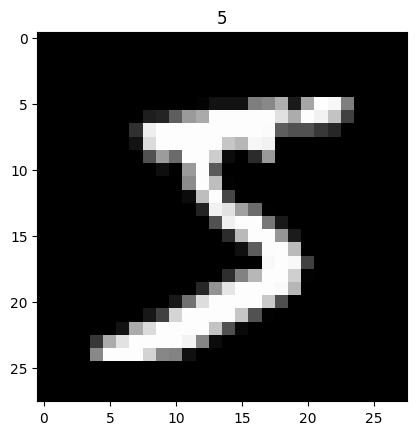

In [30]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

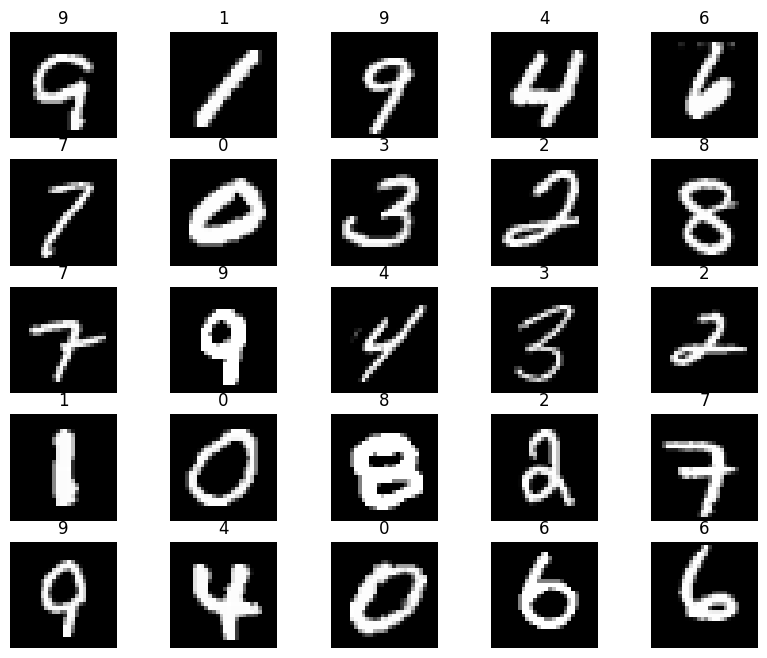

In [31]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [32]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=600, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=600, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9707db04c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f9707db0670>}

In [33]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [34]:
model = CNN()
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [35]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [36]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 1e-3,  betas=(0.9, 0.999))   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [37]:
from torch.autograd import Variable
num_epochs = 7
losses_adam = []

def train(num_epochs, model, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
    first = True
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            losses_adam.append(loss.item())    
            # backpropagation, compute gradients 
            loss.backward()
            #losses_adam.append(loss.data.numpy())    
            
            # apply gradients             
            optimizer.step()                
            if first:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i, total_step, loss.item()))
                first = False
                
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

train(num_epochs, model, loaders)

Epoch [1/7], Step [0/100], Loss: 2.3153
Epoch [1/7], Step [100/100], Loss: 0.1532
Epoch [2/7], Step [100/100], Loss: 0.1249
Epoch [3/7], Step [100/100], Loss: 0.0560
Epoch [4/7], Step [100/100], Loss: 0.0377
Epoch [5/7], Step [100/100], Loss: 0.0677
Epoch [6/7], Step [100/100], Loss: 0.0375
Epoch [7/7], Step [100/100], Loss: 0.0432


In [38]:
model = CNN()
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [39]:
import torch
from torch.optim import Adam

class NoBiasCorrectionAdam(Adam):
    def __init__(self, *args, **kwargs):
        super(NoBiasCorrectionAdam, self).__init__(*args, **kwargs)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('NoBiasCorrectionAdam does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Update the weights without bias correction
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                step_size = group['lr']
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [40]:
from torch import optim
#optimizer = optim.Adam(model.parameters(), lr = 1e-3,  betas=(0, 0))   
optimizer = NoBiasCorrectionAdam(model.parameters(), lr = 1e-3,)
optimizer

NoBiasCorrectionAdam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [41]:
from torch.autograd import Variable
num_epochs = 7
losses_NoBiasCorrectionAdam = []

def train(num_epochs, model, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
    first = True
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = model(b_x)[0]      
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            losses_NoBiasCorrectionAdam.append(loss.item())
            # backpropagation, compute gradients 
            loss.backward()
            #losses_NoBiasCorrectionAdam.append(loss.data.numpy())  
               
            # apply gradients             
            optimizer.step()                
            if first:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i, total_step, loss.item()))
                first = False
                
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


train(num_epochs, model, loaders)

Epoch [1/7], Step [0/100], Loss: 2.3023
Epoch [1/7], Step [100/100], Loss: 0.0704
Epoch [2/7], Step [100/100], Loss: 0.0655
Epoch [3/7], Step [100/100], Loss: 0.0296
Epoch [4/7], Step [100/100], Loss: 0.0234
Epoch [5/7], Step [100/100], Loss: 0.0298
Epoch [6/7], Step [100/100], Loss: 0.0316
Epoch [7/7], Step [100/100], Loss: 0.0400


In [42]:
print(len(losses_adam))

700


In [43]:
print(len(losses_NoBiasCorrectionAdam))

700


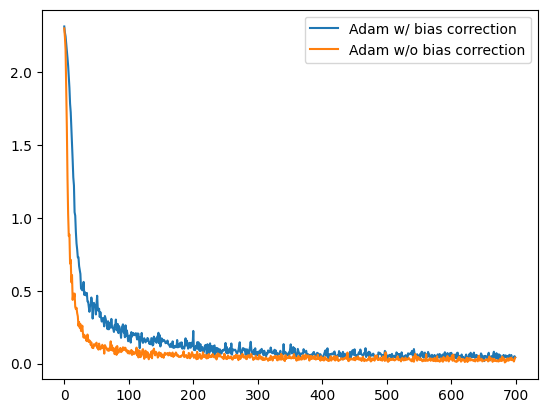

In [44]:
import matplotlib.pyplot as plt

plt.plot(losses_adam, label = 'Adam w/ bias correction')
plt.plot(losses_NoBiasCorrectionAdam, label = 'Adam w/o bias correction')
plt.legend(loc='best')
